<a href="https://www.kaggle.com/code/guptamols/categorical-embedding?scriptVersionId=214699069" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

https://towardsdatascience.com/deep-learning-for-tabular-data-using-pytorch-1807f2858320

https://arxiv.org/pdf/1604.06737

### Loading and pre-processing data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shelter-animal-outcomes/sample_submission.csv.gz
/kaggle/input/shelter-animal-outcomes/train.csv.gz
/kaggle/input/shelter-animal-outcomes/test.csv.gz


In [2]:
train=pd.read_csv('/kaggle/input/shelter-animal-outcomes/train.csv.gz')
test=pd.read_csv('/kaggle/input/shelter-animal-outcomes/test.csv.gz')

In [3]:
train.head(2)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby


In [4]:
X=train.drop(['OutcomeType','OutcomeSubtype','Name','AnimalID','DateTime'],axis=1)
y=train['OutcomeType']

y=y.astype('category').cat.codes

In [5]:
# from categorical columns, take out embedding columns
categorical_columns = X.select_dtypes(include='object').columns
categorical_columns

embedding_columns=[]
for col in categorical_columns:
    unique_values=X[col].nunique()
    if unique_values>2:
        embedding_columns.append(col)
embedding_columns

['SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color']

In [6]:
categories_dict={}
for col in categorical_columns:
    X[col].fillna('Unknown', inplace=True)
    categories_dict[col]=X[col].unique().tolist()
    #X[col].astype('category').cat.codes.unique().tolist()
    X[col] = X[col].astype('category')
    X[col] = X[col].cat.codes

In [7]:
emb_c={col:X[col].nunique() for col in embedding_columns}
emb_szs = [(c, min(50, (c + 1) // 2)) for _, c in emb_c.items()]  # Embedding sizes
emb_szs,emb_c

([(5, 3), (45, 23), (1380, 50), (366, 50)],
 {'SexuponOutcome': 5, 'AgeuponOutcome': 45, 'Breed': 1380, 'Color': 366})

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # Stratify ensures class balance
)

In [9]:
from torch.utils.data import Dataset,DataLoader
import numpy as np  # Ensure numpy is also imported

class ShelterOutcomeDataset(Dataset):
    def __init__(self, X, Y, emb_cols):
        X = X.copy()
        self.X1 = X.loc[:,emb_cols].copy().values.astype(np.int64) #categorical columns
        self.X2 = X.drop(columns=emb_cols).copy().values.astype(np.float32) #numerical columns
        self.y = Y.values.astype(np.int64)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X1[idx], self.X2[idx], self.y[idx]

In [10]:
train_ds = ShelterOutcomeDataset(X_train, y_train, embedding_columns)
valid_ds = ShelterOutcomeDataset(X_val, y_val, embedding_columns)

batch_size = 1000
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True,drop_last=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size,shuffle=True,drop_last=True)

### Model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ShelterOutcomeModel(nn.Module):
    def __init__(self, embedding_sizes, n_cont):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(categories, size) for categories,size in embedding_sizes])
        n_emb = sum(e.embedding_dim for e in self.embeddings) #length of all embeddings combined
        self.n_emb, self.n_cont = n_emb, n_cont
        self.lin1 = nn.Linear(self.n_emb + self.n_cont, 200)
        self.lin2 = nn.Linear(200, 70)
        self.lin3 = nn.Linear(70, 5)
        self.bn1 = nn.BatchNorm1d(self.n_cont)
        self.bn2 = nn.BatchNorm1d(200)
        self.bn3 = nn.BatchNorm1d(70)
        self.emb_drop = nn.Dropout(0.6)
        self.drops = nn.Dropout(0.3)
        

    def forward(self, x_cat, x_cont):
        #import pdb ; pdb.set_trace()

        #print([(e,torch.unique(x_cat[:,i]).numel()) for i,e in enumerate(self.embeddings)])
        #print([(e,torch.unique(x_cat[:,i])) for i,e in enumerate(self.embeddings)])
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embeddings)]
        x = torch.cat(x, 1)
        x = self.emb_drop(x)
        x2 = self.bn1(x_cont)
        x = torch.cat([x, x2], 1)
        x = F.relu(self.lin1(x))
        x = self.drops(x)
        x = self.bn2(x)
        x = F.relu(self.lin2(x))
        x = self.drops(x)
        x = self.bn3(x)
        x = self.lin3(x)
        return x

In [12]:
n_cont = X_train.shape[1] - len(embedding_columns)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ShelterOutcomeModel(emb_szs, n_cont).to(device)

loss_fn = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Learning rate can be adjusted

### Train Model

In [13]:
epochs = 100
train_loss_values=[]
validation_loss_values=[]

for epoch in range(epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    
    for x_cat, x_cont, y in train_dl:
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device).long()  # Cast y to long
        preds = model(x_cat, x_cont)
        loss = loss_fn(preds, y)

        # Forward pass
        preds = model(x_cat, x_cont)
        loss = loss_fn(preds, y)

        # Backward pass
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        train_loss += loss.item()

    # Validation loop after each epoch
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation for validation
        for x_cat, x_cont, y in valid_dl:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            preds = model(x_cat, x_cont)
            loss = loss_fn(preds, y)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(preds, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    val_accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dl):.4f}, "
          f"Validation Loss: {val_loss/len(valid_dl):.4f}, Accuracy: {val_accuracy:.4f}")

    train_loss_values.append(train_loss/len(train_dl))
    validation_loss_values.append(val_loss/len(valid_dl))



# Save the model after training
torch.save(model.state_dict(), "shelter_outcome_model.pth")

Epoch 1/100, Train Loss: 1.5792, Validation Loss: 1.3904, Accuracy: 0.5014
Epoch 2/100, Train Loss: 1.4546, Validation Loss: 1.2951, Accuracy: 0.5322
Epoch 3/100, Train Loss: 1.3861, Validation Loss: 1.2161, Accuracy: 0.5406
Epoch 4/100, Train Loss: 1.3132, Validation Loss: 1.1615, Accuracy: 0.5530
Epoch 5/100, Train Loss: 1.2517, Validation Loss: 1.1241, Accuracy: 0.5584
Epoch 6/100, Train Loss: 1.1920, Validation Loss: 1.0847, Accuracy: 0.5656
Epoch 7/100, Train Loss: 1.1515, Validation Loss: 1.0613, Accuracy: 0.5636
Epoch 8/100, Train Loss: 1.1226, Validation Loss: 1.0315, Accuracy: 0.5762
Epoch 9/100, Train Loss: 1.0932, Validation Loss: 1.0218, Accuracy: 0.5694
Epoch 10/100, Train Loss: 1.0812, Validation Loss: 1.0075, Accuracy: 0.5778
Epoch 11/100, Train Loss: 1.0670, Validation Loss: 0.9980, Accuracy: 0.5808
Epoch 12/100, Train Loss: 1.0561, Validation Loss: 0.9896, Accuracy: 0.5830
Epoch 13/100, Train Loss: 1.0481, Validation Loss: 0.9803, Accuracy: 0.5886
Epoch 14/100, Train L

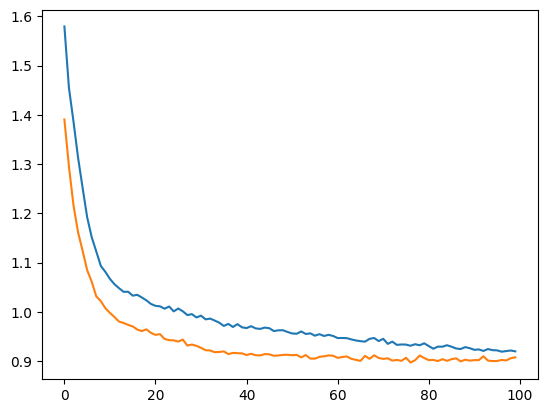

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(train_loss_values)
plt.plot(validation_loss_values)

### Re-train model on optimal epochs

In [15]:
epochs = 20
train_loss_values=[]
validation_loss_values=[]

for epoch in range(epochs):
    model.train()  # Set model to training mode
    train_loss = 0
    
    for x_cat, x_cont, y in train_dl:
        x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device).long()  # Cast y to long
        preds = model(x_cat, x_cont)
        loss = loss_fn(preds, y)

        # Forward pass
        preds = model(x_cat, x_cont)
        loss = loss_fn(preds, y)

        # Backward pass
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update weights

        train_loss += loss.item()

    # Validation loop after each epoch
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient computation for validation
        for x_cat, x_cont, y in valid_dl:
            x_cat, x_cont, y = x_cat.to(device), x_cont.to(device), y.to(device)

            preds = model(x_cat, x_cont)
            loss = loss_fn(preds, y)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(preds, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    val_accuracy = correct / total
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_dl):.4f}, "
          f"Validation Loss: {val_loss/len(valid_dl):.4f}, Accuracy: {val_accuracy:.4f}")

    train_loss_values.append(train_loss/len(train_dl))
    validation_loss_values.append(val_loss/len(valid_dl))



# Save the model after training
torch.save(model.state_dict(), "shelter_outcome_model.pth")

Epoch 1/20, Train Loss: 0.9153, Validation Loss: 0.9019, Accuracy: 0.6296
Epoch 2/20, Train Loss: 0.9163, Validation Loss: 0.8996, Accuracy: 0.6300
Epoch 3/20, Train Loss: 0.9177, Validation Loss: 0.9052, Accuracy: 0.6268
Epoch 4/20, Train Loss: 0.9165, Validation Loss: 0.9005, Accuracy: 0.6292
Epoch 5/20, Train Loss: 0.9149, Validation Loss: 0.9078, Accuracy: 0.6260
Epoch 6/20, Train Loss: 0.9171, Validation Loss: 0.9046, Accuracy: 0.6292
Epoch 7/20, Train Loss: 0.9123, Validation Loss: 0.9042, Accuracy: 0.6282
Epoch 8/20, Train Loss: 0.9141, Validation Loss: 0.9003, Accuracy: 0.6310
Epoch 9/20, Train Loss: 0.9122, Validation Loss: 0.9024, Accuracy: 0.6308
Epoch 10/20, Train Loss: 0.9127, Validation Loss: 0.9017, Accuracy: 0.6328
Epoch 11/20, Train Loss: 0.9119, Validation Loss: 0.9050, Accuracy: 0.6300
Epoch 12/20, Train Loss: 0.9088, Validation Loss: 0.8970, Accuracy: 0.6320
Epoch 13/20, Train Loss: 0.9092, Validation Loss: 0.8995, Accuracy: 0.6300
Epoch 14/20, Train Loss: 0.9091, V

### Insights - Categorical feature : AgeUponOutcome

In [16]:
categories_dict.keys()

dict_keys(['AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color'])

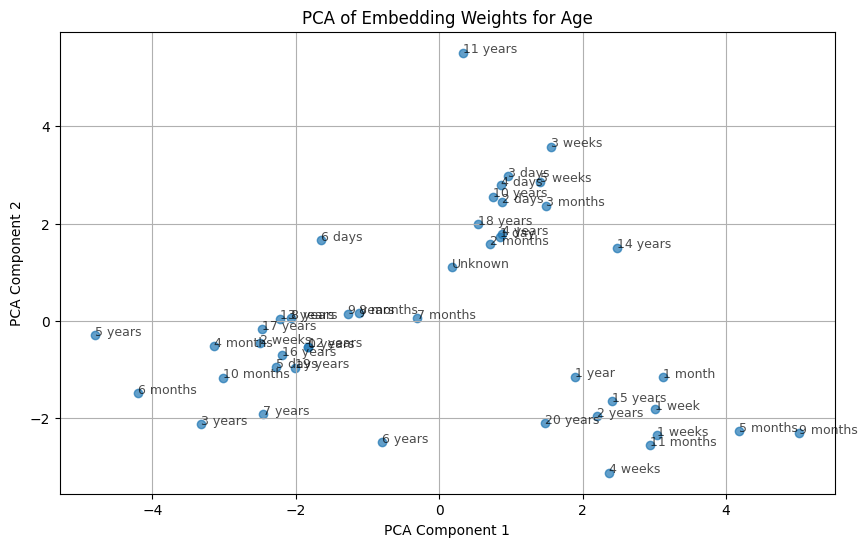

In [17]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Assuming you have the model already defined and trained
# Access the weights from the second embedding layer (corresponding to "age")
weights_age = model.embeddings[1].weight.data.numpy()  # Convert to NumPy array

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(weights_age)

# Create a scatter plot of the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)

# Label each point with the corresponding age category (assuming categorical encoding)
# Replace 'range(weights_age.shape[0])' with the actual age categories if available
list_=categories_dict['AgeuponOutcome']
for i in range(weights_age.shape[0]):
    plt.annotate(f'{list_[i]}', (pca_result[i, 0], pca_result[i, 1]), fontsize=9, alpha=0.7)

plt.title("PCA of Embedding Weights for Age")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()


In [18]:
explained_variance = pca.explained_variance_ratio_
explained_variance.sum()

0.3890611

### Insights - Categorical feature : SexuponOutcome

Explained Variance for PCA Components (Sex):
1st Component: 0.5805 (58.05%)
2nd Component: 0.4194 (41.94%)


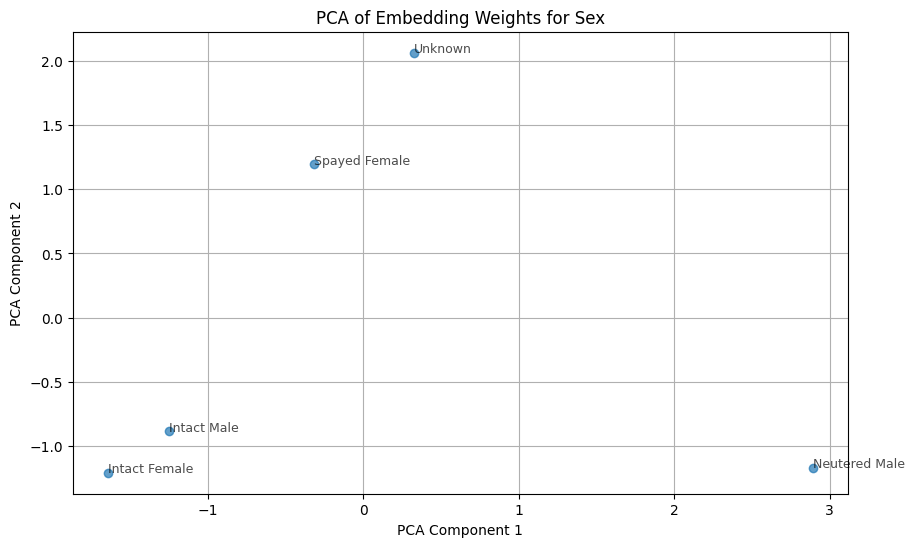

In [19]:
weights_sex = model.embeddings[0].weight.data.numpy()  # Convert to NumPy array

# Perform PCA
pca_sex = PCA(n_components=2)
pca_result_sex = pca_sex.fit_transform(weights_sex)

# Get explained variance ratio
explained_variance_sex = pca_sex.explained_variance_ratio_

# Print explained variance
print(f"Explained Variance for PCA Components (Sex):")
print(f"1st Component: {explained_variance_sex[0]:.4f} ({explained_variance_sex[0] * 100:.2f}%)")
print(f"2nd Component: {explained_variance_sex[1]:.4f} ({explained_variance_sex[1] * 100:.2f}%)")

# Create a scatter plot of the PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_result_sex[:, 0], pca_result_sex[:, 1], alpha=0.7)

# Label each point with the corresponding sex category
list_=categories_dict['SexuponOutcome']
for i in range(weights_sex.shape[0]):
    plt.annotate(f'{list_[i]}', (pca_result_sex[i, 0], pca_result_sex[i, 1]), fontsize=9, alpha=0.7)

plt.title("PCA of Embedding Weights for Sex")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid()
plt.show()

### Color

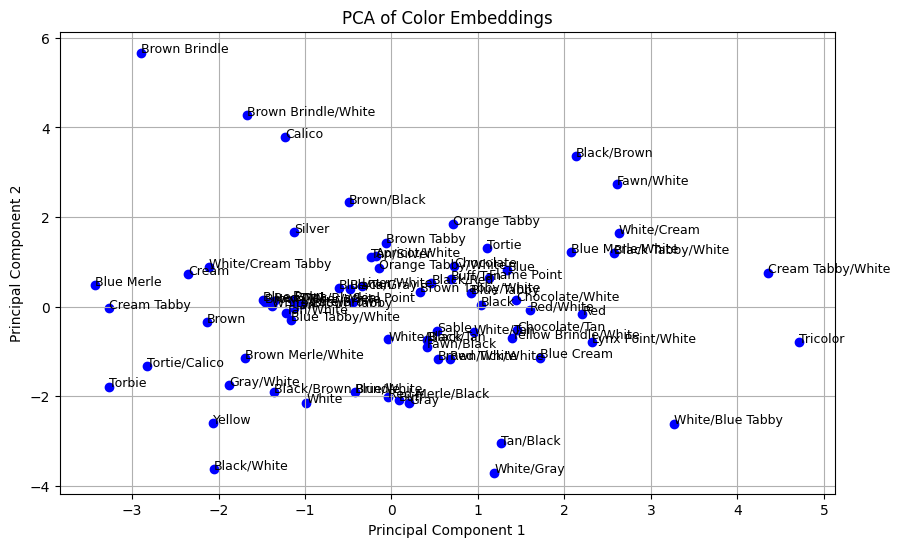

Explained variance ratio: 0.12064386598795827


In [20]:
color_embedding_weights = model.embeddings[3].weight.data  # Adjust index if necessary

# Get unique colors from the categories_dict
unique_colors = categories_dict['Color']

# Select 10% of the unique categories (colors)
num_colors = len(unique_colors)
num_colors_to_select = max(1, num_colors // 5)  # Ensure at least one color is selected
selected_colors = unique_colors[:num_colors_to_select]

# Get the corresponding embeddings for the selected colors
color_embeddings = color_embedding_weights[:num_colors_to_select]

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(color_embeddings)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='blue')

# Annotate points with corresponding color names
for i, color in enumerate(selected_colors):
    plt.annotate(color, (pca_result[i, 0], pca_result[i, 1]), fontsize=9)

plt.title('PCA of Color Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Print explained variance ratio
print(f'Explained variance ratio: {pca.explained_variance_ratio_.sum()}')